### Disclaimer: le code ci-dessous est produit pour de l'analyse de données vite-fait-bien-fait, il ne faut donc pas trop juger la qualité du code

In [1]:
from bs4 import BeautifulSoup
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

## Récupération des données

In [2]:
# Il faut d'abord récupérer les scrutins de l'assemblée nationale, j'ai fait ça rapidement avec du bash
# Un comportement équivalent pourrait être simplement codé avec les librairies os et urllib
"""
mkdir -p pages;
cd pages;
for n in {1..1380..1}; 
  do wget "http://www2.assemblee-nationale.fr/scrutins/detail/(legislature)/14/(num)/$n";
done
"""

'\nmkdir -p pages;\ncd pages;\nfor n in {1..1380..1}; \n  do wget "http://www2.assemblee-nationale.fr/scrutins/detail/(legislature)/14/(num)/$n";\ndone\n'

In [3]:
# Traitement des pages pour enregistrer les infos pertinentes dans des structures plus tractables
pages = !ls pages
res = {}
for pe in pages:
    page = BeautifulSoup(open('pages/' + pe), 'lxml')
    # Meta infos
    a, b, _ = page.html.title.text.split(' - ')
    scrutin = page.find('h3', attrs={'class': 'president-title'}).text
    res[int(pe)] = { 'title': a, 'seance': b, 'scrutin': scrutin }
    # Etudier le résumé de la page
    summary = page.find('div', attrs={'class': 'interieur-media-moyenne-colonne-scrutin'})
    res_summary = []
    for p in summary.find_all('p', attrs={'class': 'repartitionvotes'}):
        tag_id = p.attrs['id'] if 'id' in p.attrs else None
        tag_title = p.text.split(':')[0].strip()
        res_summary.append({ 'id': tag_id, 'number': int(p.b.text), 'title': tag_title })
    res[int(pe)]['summary'] = res_summary
    # Etudier les différents groupes
    group_votes = {}
    for div in page.find_all('div', attrs={'class': 'TTgroupe'}):
        votes = {}
        for opinion in div.find_all('div'):
            lis = [ li.text.strip().replace('\xa0', ' ') for li in opinion.find_all('li') ]
            if lis == []:
                _lis = opinion.ul.text.strip(' .\t\n').replace('\xa0', ' ')
                lis = _lis.replace(', ', ' et ').split(' et ')
            for prefix in ['MM. ', 'M. ', 'Mme ', 'Mmes ']:
                lis = [ li.replace(prefix, '') for li in lis ]
            votes[opinion.attrs['class'][0].rstrip('s')] = lis
        group_votes[div.p.text] = votes
    res[int(pe)]['group_votes'] = group_votes
    # Mises au point
    span = page.find('span', string='Mises au point')
    if span:
        maj = []
        for el in span.parent.next_elements:
            if el.name == 'div':
                break
        for p in el.find_all('p', attrs={'class': 'itemmap'}):
            if len(p.text) > 0:
                maj.append(p.text.strip().replace('\xa0', ' '))
        res[int(pe)]['maj'] = maj

In [4]:
# On enregistre le tout pour ne pas avoir à tout recalculer à chaque fois qu'on relance Jupyter
with open('data.json', 'w') as jsonfile:
    json.dump(res, jsonfile)

## Reprendre ici si vous avez relancé Jupyter

In [5]:
with open('data.json', 'r') as infile:
    data_votes = json.load(infile)

## Analyse des groupes

In [6]:
group_counts = {}
index = [str(i) for i in sorted([int(i) for i in data_votes.keys()])]
for i in index:
    data = data_votes[i]
    date_vote = pd.to_datetime(data['seance'].split()[-1], dayfirst=True)
    tmp = {}
    for group in data['group_votes']:
        name, _num = group.split(' (')
        num = int(_num.split()[0])
        tmp[name] = num
    group_counts[date_vote] = tmp
group_counts = pd.DataFrame(group_counts).fillna(0).astype(int)

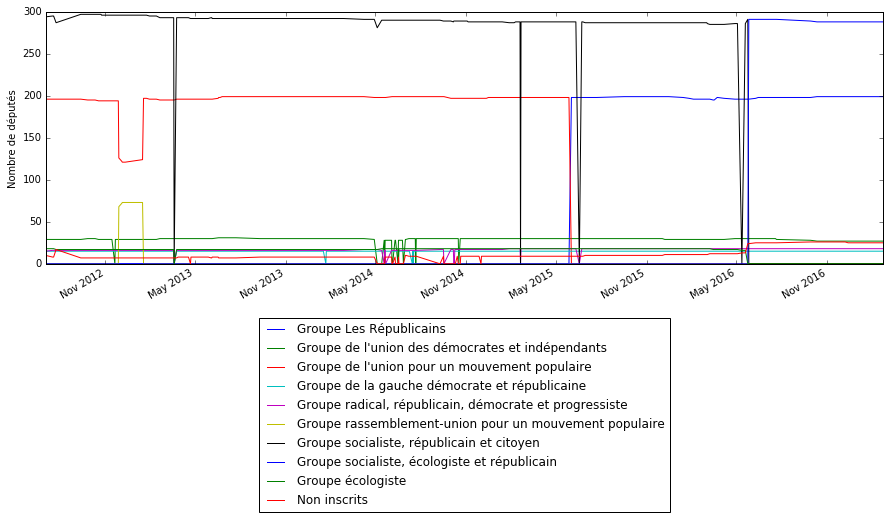

In [7]:
plot = group_counts.transpose().plot(figsize=(15,5))
plot.set_ylabel('Nombre de députés')
plot.legend(loc='center', bbox_to_anchor=(0.5, -0.6))

In [8]:
group_counts.transpose().drop_duplicates()

,Groupe Les Républicains,Groupe de l'union des démocrates et indépendants,Groupe de l'union pour un mouvement populaire,Groupe de la gauche démocrate et républicaine,"Groupe radical, républicain, démocrate et progressiste",Groupe rassemblement-union pour un mouvement populaire,"Groupe socialiste, républicain et citoyen","Groupe socialiste, écologiste et républicain",Groupe écologiste,Non inscrits
2012-07-03,0,29,196,15,15,0,294,0,18,10
2012-07-17,0,29,196,15,16,0,295,0,18,8
2012-07-24,0,29,196,15,16,0,287,0,17,17
2012-09-12,0,29,196,15,16,0,297,0,17,7
2012-09-25,0,30,195,15,16,0,297,0,17,7
2012-10-18,0,29,194,15,16,0,297,0,17,7
2012-10-24,0,29,194,15,16,0,296,0,17,7
2012-11-20,0,0,194,15,16,0,296,0,17,7
2012-11-28,0,29,126,15,16,68,296,0,17,7
2012-12-04,0,29,122,15,16,72,296,0,17,7


## Analyse du résumé des scrutins

In [9]:
df_array = []
index = [str(i) for i in sorted([int(i) for i in data_votes.keys()])]
for i in index:
    data = data_votes[i]
    _date = pd.to_datetime(data['seance'].split()[-1], dayfirst=True)
    _scrutin = data['scrutin']
    for votes in data['summary']:
        if votes['id'] == 'total':
            _total = votes['number']
        elif votes['id'] == 'pour':
            _for = votes['number']
        elif votes['id'] == 'contre':
            _against = votes['number']
    df_array.append([int(i), _date, _scrutin, _total, _for, _against])
df = pd.DataFrame(df_array, columns=['idx', 'date', 'scrutin', 'total', 'for', 'against'])
df = df.set_index('idx')
df_won = df[df['for'] > df['against']]
df_lost = df[df['for'] <= df['against']]

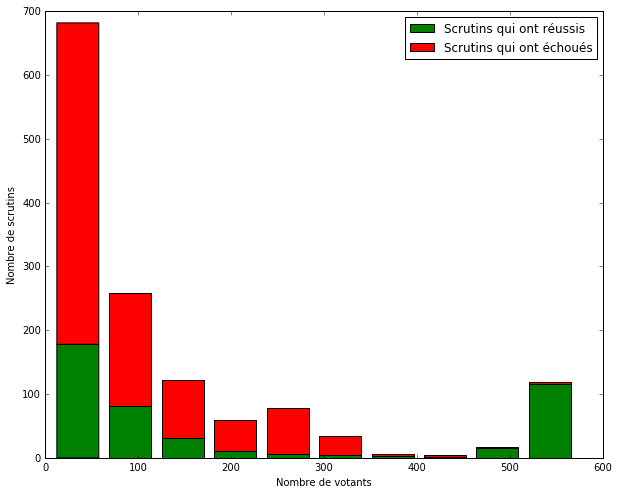

In [10]:
plt.hist([df_won.total, df_lost.total], stacked=True, color=['g', 'r'])
lgd = plt.legend(['Scrutins qui ont réussis', 'Scrutins qui ont échoués'])
lgd.axes.set_xlabel("Nombre de votants")
lgd.axes.set_ylabel("Nombre de scrutins")
fig = plt.gcf()
fig.set_size_inches(10, 8)

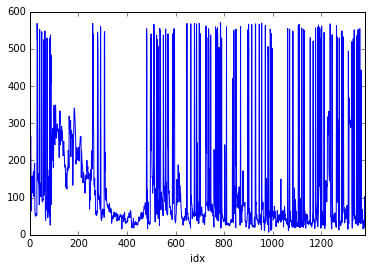

In [11]:
df.total.plot()

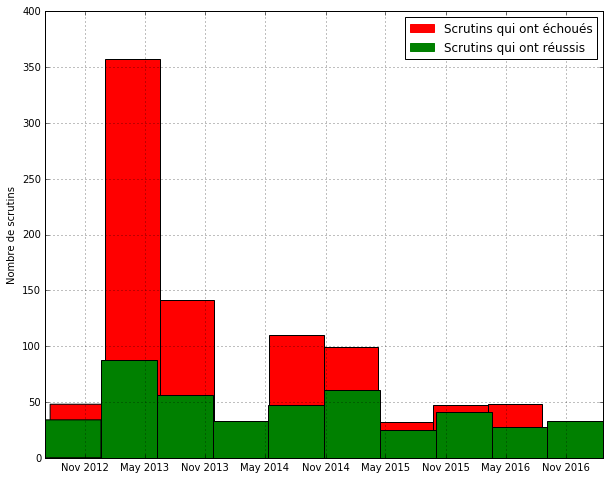

In [12]:
df[df['for'] < df['against']].date.hist(figsize=(10,8), color=['r'])
df[df['for'] > df['against']].date.hist(figsize=(10,8), color=['g'])
red_patch = mpatches.Patch(color='red', label='Scrutins qui ont échoués')
green_patch = mpatches.Patch(color='green', label='Scrutins qui ont réussis')
plt.legend(handles=[red_patch, green_patch]).axes.set_ylabel('Nombre de scrutins')

In [13]:
pd.Series([1]*1380, index=df.date.values).resample('1A').sum()

2012-12-31     82
2013-12-31    676
2014-12-31    239
2015-12-31    213
2016-12-31    155
2017-12-31     15
Freq: A-DEC, dtype: int64

## TOP 10 des scrutins

In [14]:
_tmp = df.sort_values('total')
for line in _tmp[:10].values:
    d, s, t, f, a = line
    print(d.strftime('%Y-%m-%d'), '=> votes:', t, '(%d pour, %d contre)' % (f, a))
    print(s)
    print()
print('-----------------------')
print()
for line in reversed(_tmp[-10:].values):
    d, s, t, f, a = line
    print(d.strftime('%Y-%m-%d'), '=> votes:', t, '(%d pour, %d contre)' % (f, a))
    print(s)
    print()

2014-12-05 => votes: 7 (4 pour, 2 contre)
Scrutin public sur l'amendement n° 325 ( 2e rect) de M. Jean-Louis Dumont après l'article 31 du projet de loi de finances rectificative pour 2014 (première lecture).

2014-11-20 => votes: 11 (2 pour, 7 contre)
Scrutin public sur l'amendement n° 2 de Mme Fraysse à l'article 2 du projet de loi relatif à la désignation des conseillers prud'hommes.

2014-11-20 => votes: 11 (2 pour, 7 contre)
Scrutin public sur les amendements identiques de suppression n° 1 de Mme Fraysse et n° 7 de M. Cavard à l'article premier du projet de loi relatif à la désignation des conseillers prud'hommes.

2015-03-16 => votes: 11 (5 pour, 6 contre)
Scrutin public sur l'amendement n° 164 de M. Laffineur et les amendements identiques n° 193 (rect) de M. Salen, n° 755 de M. Plisson, n° 1084 de M. Krabal, n° 1223 de M. Cinieri et n° 1348 (rect) de M. Chassaigne de M. après l'article 2 du projet de loi relatif à la biodiversité.

2014-12-12 => votes: 12 (8 pour, 4 contre)
Scrut

In [15]:
_tmp = df.sort_values('for')
for line in reversed(_tmp[-10:].values):
    d, s, t, f, a = line
    print(d.strftime('%Y-%m-%d'), '=> votes:', t, '(%d pour, %d contre)' % (f, a))
    print(s)
    print()

2015-11-19 => votes: 558 (551 pour, 6 contre)
Scrutin public sur l'ensemble du projet de loi prorogeant l'application de la loi n° 55-385 du 3 avril 1955 relative à l'état d'urgence et renforçant l'efficacité de ses dispositions (première lecture).

2015-11-25 => votes: 529 (515 pour, 4 contre)
Scrutin public sur l'autorisation de la prolongation de l'engagement des forces aériennes au-dessus du territoire syrien, en application de l'article 35, alinéa 3, de la Constitution.

2016-10-18 => votes: 527 (511 pour, 1 contre)
Scrutin public sur le projet de loi de modernisation, de développement et de protection des territoires de montagne (première lecture).

2012-10-10 => votes: 542 (490 pour, 34 contre)
Scrutin public sur sur l'ensemble du projet de loi organique relatif à la programmation et à la gouvernance des finances publiques.

2016-07-19 => votes: 519 (489 pour, 26 contre)
Scrutin public sur l'ensemble du projet de loi prorogeant l'application de la loi n° 55-385 du 3 avril 1955 r

In [16]:
_tmp = df.sort_values('against')
for line in reversed(_tmp[-10:].values):
    d, s, t, f, a = line
    print(d.strftime('%Y-%m-%d'), '=> votes:', t, '(%d pour, %d contre)' % (f, a))
    print(s)
    print()

2012-11-13 => votes: 524 (207 pour, 317 contre)
Scrutin public sur la demande de constitution d'une commission spéciale présentée par le président du groupe de l'Union pour un mouvement populaire pour l'examen du projet de loi ouvrant le mariage aux couples de personnes de même sexe.

2013-01-30 => votes: 483 (184 pour, 298 contre)
Scrutin public sur la motion référendaire, présentée par M. Christian Jacob, du projet de loi ouvrant le mariage aux couples de personnes de même sexe.

2016-06-21 => votes: 529 (227 pour, 291 contre)
Scrutin public sur l'ensemble de la proposition de loi constitutionnelle visant à rendre constitutionnel le principe d'indisponibilité du corps humain (première lecture).

2013-02-03 => votes: 309 (18 pour, 279 contre)
Scrutin public sur l'amendement n° 2157 de M.Sergio Coronado avant l'article 1er bis du projet de loi portant ouverture du mariage aux couples de personnes de même sexe (PMA et filiation de la conjointe).

2013-01-29 => votes: 442 (169 pour, 272 